# Classificazione video con mediapipe

In questo notebook vengono caricati i video preprocessati e vengono estratti i keypoint relativi alle mani dei soggetti. Vengono poi calcolate le distanze DTW tra i video di test e i video del training set, e viene effettuata la classificazione. Viene infine stampata la confusion matrix e l'istogramma delle distanze DTW.


## Import delle librerie

In [1]:
from handcrafted.app.dataset.dataset import Dataset
from handcrafted.app.features.plotter.frames_plotter import plot_frames
from wlasl_mediapipe.app.dtw.dtw import classify, pretty_print
from wlasl_mediapipe.app.utils.mp.helper.landmark_drawer import (
    draw_landmarks_on_image,
)
from wlasl_mediapipe.launcher import Launcher
from handcrafted.app.model.model_statistics import ModelStatistics

import mediapipe as mp
import matplotlib.pyplot as plt

2025-03-18 17:41:03.318099: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 17:41:03.318539: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-18 17:41:03.323060: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-18 17:41:03.354430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-18 17:41:04.349000: W tensorflow/compiler/tf2tensorrt/utils/py_uti

## Import del dataset

Tramite la classe di utilità [Launcher](./wlasl_mediapipe/launcher.py) vengono caricati i video preprocessati e i glosses relativi alle parole da classificare.
Si è scelto di caricare solo i primi 5 glosses per ridurre i tempi di esecuzione.
Nella funzione `load_glosses` il parametro `filtered` permette di caricare solo le parole filtrate utilizzando `fasttext` o tutte le parole presenti nel dataset.

In [2]:
launcher = Launcher()
data = launcher.load_data()
glosses = launcher.load_glosses(filtered=False)[5:11]

## Video di esempio

Si va a mostrare un esempio dei keypoint estratti da `MediaPipe` su due frame di due video diversi.
Viene utilizata la classe `Holistic` di `MediaPipe` per estrarre i keypoint relativi alle mani, al viso e alla posa dei soggetti.

Tramite la funzione di utilità `draw_landmarks_on_image` vengono disegnati i keypoint sul frame da cui sono stati estratti.

E0000 00:00:1742316066.515085  417979 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1742316066.515184  417979 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1742316066.515190  417979 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1742316066.515196  417979 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1742316066.515202  417979 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1742316066.51

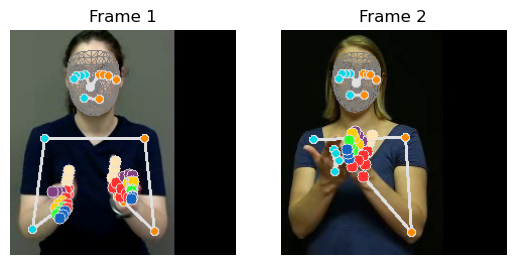

In [3]:
dataset = Dataset("data/WLASL_v0.3.json")

mp_holistic = mp.solutions.holistic
detector = mp_holistic.Holistic(
    static_image_mode=True,
    model_complexity=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    refine_face_landmarks=True,
)

image_1 = dataset.videos[0].get_frames()[10]
image_2 = dataset.videos[1].get_frames()[10]

annotated_image_1 = draw_landmarks_on_image(image_1, detector.process(image_1))
annotated_image_2 = draw_landmarks_on_image(image_2, detector.process(image_2))
plot_frames([annotated_image_1, annotated_image_2])

## Split training e test set
La suddivisione dei video di training e di test segue la struttura definita nel file `WLASL_v0.3.json`, al training set vengono aggiunti anche i video di validation, siccome il classificatore DTW non necessita di un validation set.
Mentre i `test_videos` sono una lista di oggetti [MediapipeVideo](./wlasl_mediapipe/app/mp/mp_video.py), i `training_videos` sono un dict con chiave la label della parola e valore una lista di oggetti [Video](./handcrafted/app/dataset/video.py).
La distinzione della tipologia di dato tra `training_videos` e `test_videos` è dovuta al fatto che durante la creazione di un oggetto [MediapipeVideo](./wlasl_mediapipe/app/mp/mp_video.py) vengono caricate le features relative ai keypoint e viene inoltre calcolato l'angolo in radianti tra i landmark delle mani (i punti tra loro connessi), questo comporterebbe un utilizzo di memoria eccessivo se fatto per un elevato numero di video.


In [4]:
training_videos = launcher.get_train_videos(dataset=data, glosses=glosses)
test_videos = launcher.get_test_videos(dataset=data, glosses=glosses)

## Classificazione risultati
La classificazione viene effettuata con DTW andando a confrontare ogni video di test con tutti i video del training set. Al video viene assegnata la label pari al video del training set con distanza minima. Vengono però salvate anche le distanze con ogni altra parola del training set, creando una classifica delle parole più simili.

Una volta ottenuti i dati questi vengono passati alla funzione `classify`, in cui si può specificare il numero di augmentations da applicare ad ogni video e il numero di top predictions da considerare.
Le augmentation applicate vengono scelte casualmente tra rotazioni delle mani sugli assi x, y e z.
In questo caso per ridurre i tempi di esecuzione si è scelto di non applicare augmentation.
La classificazione viene effettuata andando a confrontare ogni video di test con tutti i video del training set, calcolando la distanza DTW tra le sequenze di features.
La metrica utilizzata per la classificazione è la DTW distance, una distanza più bassa indica una maggiore similarità tra i video.
Per calcolare la topN accuracy viene seguito un algoritmo simile a k-NN.

In [5]:
results = classify(
    test_videos=test_videos, train_videos=training_videos, augment=0, topN=5
)

100%|██████████| 6/6 [00:25<00:00,  4.19s/it]


## Stampa dei risultati

Si mostrano i risultati della classificazione, stampando la top1 e top5 accuracy.

In [6]:
pretty_print(results, "top1-res-notebook.log", 1)

Top1 score:
Real Word    Classified Words
-----------  ---------------------------------
go           [('go', 0.0)]
go           [('go', 13077.898822734527)]
clothes      [('clothes', 16033.509049673445)]
clothes      [('clothes', 13333.618005294662)]
clothes      [('clothes', 18277.217516640198)]
who          [('candy', 10840.282418727724)]
who          [('who', 7578.244239832867)]
who          [('deaf', 9482.35896514572)]
candy        [('candy', 8130.952327398601)]
candy        [('who', 4235.7870441487175)]
candy        [('candy', 6358.809594249445)]
cousin       [('cousin', 5836.856409367278)]
cousin       [('cousin', 8120.526902001565)]
deaf         [('candy', 5099.174860887556)]
deaf         [('deaf', 3261.4876862156434)]
deaf         [('deaf', 4975.947556280562)]

Accuracy: 0.75


In [7]:
pretty_print(results, "top5-res-notebook.log", 5)

Top5 score:
Real Word    Classified Words
-----------  ----------------------------------------------------------------------------------------------------------------------------------------------------------
go           [('go', 0.0), ('deaf', 9842.776831561925), ('who', 10564.379040363703), ('candy', 11386.12176230552), ('cousin', 16854.480428761624)]
go           [('go', 13077.898822734527), ('who', 14980.94977045497), ('candy', 15993.51309567788), ('clothes', 18166.530404907444), ('deaf', 18302.21139280575)]
clothes      [('clothes', 16033.509049673445), ('cousin', 23099.413082172065), ('go', 23467.123522506132), ('candy', 27075.037623490673), ('who', 29998.07046905651)]
clothes      [('clothes', 13333.618005294662), ('cousin', 20889.866922859313), ('go', 23298.400182143552), ('deaf', 23906.681284296625), ('candy', 23965.784842310633)]
clothes      [('clothes', 18277.217516640198), ('cousin', 26372.720930884207), ('who', 27997.313616817628), ('go', 28581.088676296524), ('candy', 3

In [8]:
Y_pred = [result[0][0] for result in results.values()]
Y_test = [result.video.gloss for result in results]

## Stampa della confusion matrix

Di seguito viene mostrata la confusion matrix dei risultati ottenuti, si può notare che la maggior parte delle classificazioni sono corrette e che il classificatore ha difficoltà a classificare ad esempio la parola "who", confondendola con "candy" e "deaf".
Questo è dovuto al fatto che in tutti e tre i casi il soggetto utilizza solamente l'indice della mano destra per esprimere la parola, e questo dito inoltre rimane teso per la quasi totalità del video.

Confusion matrix saved at plots/confusion_matrix_mediapipe.png


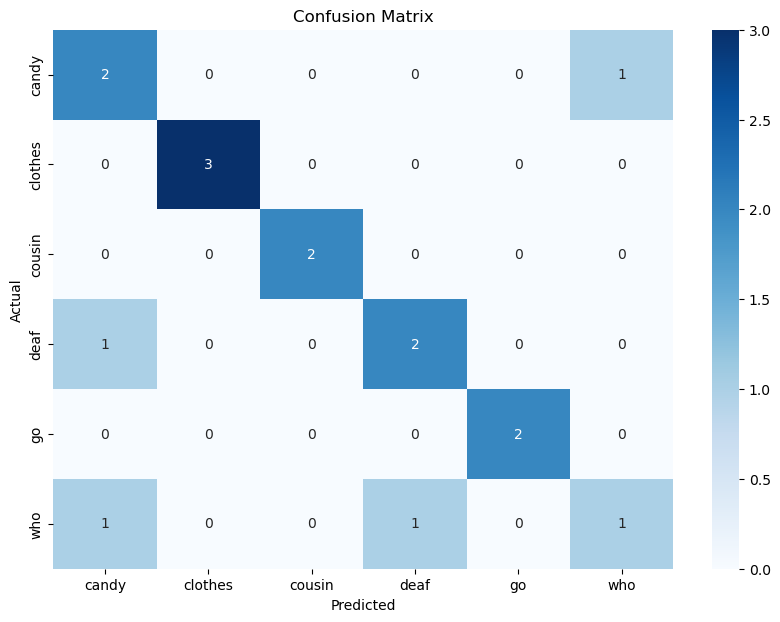

Classification Report:
               precision    recall  f1-score   support

       candy       0.50      0.67      0.57         3
     clothes       1.00      1.00      1.00         3
      cousin       1.00      1.00      1.00         2
        deaf       0.67      0.67      0.67         3
          go       1.00      1.00      1.00         2
         who       0.50      0.33      0.40         3

    accuracy                           0.75        16
   macro avg       0.78      0.78      0.77        16
weighted avg       0.75      0.75      0.74        16

Accuracy: 75.00%


In [9]:
model_stats = ModelStatistics(save_name="confusion_matrix_mediapipe", save_dir="wlasl/plots")
model_stats.plot_confusion_matrix(Y_test, Y_pred)
model_stats.print_classification_report(Y_test, Y_pred)
model_stats.print_accuracy(Y_test, Y_pred)

## Stampa dell'istogramma dei risultati
L'istogramma mostra la distribuzione delle distanze DTW tra i video di test e i video del training set. Si può notare che alcuni match errati hanno distanze DTW basse, questo è dovuto al fatto che alcune parole hanno movimenti simili.

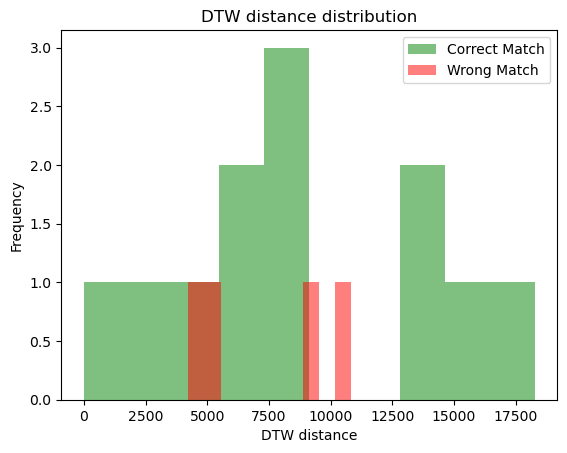

In [10]:
dtw_correct = [
    results.get(result)[0][1]
    for result in results
    if result.video.gloss == results.get(result)[0][0]
]
dtw_wrong = [
    results.get(result)[0][1]
    for result in results
    if result.video.gloss != results.get(result)[0][0]
]

plt.hist(dtw_correct, bins=10, alpha=0.5, label="Correct Match", color="green")
plt.hist(dtw_wrong, bins=10, alpha=0.5, label="Wrong Match", color="red")
plt.xlabel("DTW distance")
plt.ylabel("Frequency")
plt.legend()
plt.title("DTW distance distribution")
plt.show()